In [1]:
import sagemaker
import boto3
from sagemaker.inputs import TrainingInput
from sagemaker import Session
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from sagemaker import image_uris

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
role = get_execution_role()
session = Session()
region = session.boto_region_name

# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":"300"}

# set an output path where the trained model will be saved
bucket = 'sagemaker-us-east-1-922945788052'
s3_output_key = 'models/xgboost/v1'
output_path = f's3://{bucket}/{s3_output_key}'

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

# construct a SageMaker AI estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=role,
                                          instance_count=2, 
                                          instance_type='ml.m5.large', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

In [3]:
# define the data type and paths to the training and validation datasets
content_type = "text/csv"
bucket = 'sagemaker-us-east-1-922945788052'
prefix = 'processed_data'

train_input = TrainingInput(f"s3://{bucket}/{prefix}/train.csv", content_type=content_type)
validation_input = TrainingInput(f"s3://{bucket}/{prefix}/validation.csv", content_type=content_type)

In [4]:
f"s3://{bucket}/{prefix}/train.csv"

's3://sagemaker-us-east-1-922945788052/processed_data/train.csv'

In [5]:
# execute the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input}, wait=True, logs="All")

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-05-30-16-29-11-781


2025-05-30 16:29:12 Starting - Starting the training job...
2025-05-30 16:29:33 Starting - Preparing the instances for training...
2025-05-30 16:29:58 Downloading - Downloading input data......
2025-05-30 16:30:53 Downloading - Downloading the training image.....[2025-05-30 16:31:56.442 ip-10-0-66-103.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-05-30 16:31:56.467 ip-10-0-66-103.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-05-30:16:31:56:INFO] Imported framework sagemaker_xgboost_container.training
[2025-05-30:16:31:56:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2025-05-30:16:31:56:INFO] No GPUs detected (normal if no gpus installed)
[2025-05-30:16:31:56:INFO] Running XGBoost Sagemaker in algorithm mode
[2025-05-30:16:31:56:INFO] Determined 0 GPU(s) available on the instance.
[2025-05-30:16:31:56:INFO] Determined delimiter of CSV input is ','
[2025-05-30:1

model data saved to `s3://sagemaker-us-east-1-922945788052/models/xgboost/v1/sagemaker-xgboost-2025-05-30-16-29-11-781/output/model.tar.gz`

# Test XGBOOST Model


In [10]:
# download test data locally
bucket = 'sagemaker-us-east-1-922945788052'
prefix = 'processed_data/test.csv'
local_file = '../data/local_test_data/test.csv'

s3 = boto3.client('s3')
s3.download_file(bucket, prefix, local_file)
print(f"Downloaded {prefix} from S3 to {local_file}")

Downloaded processed_data/test.csv from S3 to ../data/local_test_data/test.csv


In [11]:
import pandas as pd
df_test = pd.read_csv(local_file)

In [12]:
y_test = df_test.iloc[:, 0].astype(int)  # first column = label
X_test = df_test.iloc[:, 1:]             # rest = features

In [15]:
# Download model
bucket = 'sagemaker-us-east-1-922945788052'
model_key = 'models/xgboost/v1/sagemaker-xgboost-2025-05-30-16-29-11-781/output/model.tar.gz'
local_file = '../data/local_model_data/xgboost-v1/model.tar.gz'

s3 = boto3.client('s3')
s3.download_file(bucket, model_key, local_file)
print(f"Downloaded {model_key} from S3 to {local_file}")

Downloaded models/xgboost/v1/sagemaker-xgboost-2025-05-30-16-29-11-781/output/model.tar.gz from S3 to ../local_model_data/xgboost-v1/model.tar.gz


In [18]:
import tarfile

# Specify your desired target directory
target_dir = "../data/local_model_data/xgboost-v1/"

with tarfile.open(local_file) as tar:
    tar.extractall(path=target_dir)

print(f"Model extracted to {target_dir}")

Model extracted to ../local_model_data/xgboost-v1/


/tmp/ipykernel_233/3262553858.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=target_dir)


In [20]:
import xgboost as xgb

booster = xgb.Booster()
booster.load_model('../data/local_model_data/xgboost-v1/xgboost-model')  # built-in XGBoost saves as this name
print("Model loaded!")

Model loaded!


In [21]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

dtest = xgb.DMatrix(X_test)
y_pred_prob = booster.predict(dtest)
y_pred = (y_pred_prob >= 0.5).astype(int)

In [22]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     15142
           1       0.99      1.00      1.00     20227

    accuracy                           1.00     35369
   macro avg       1.00      0.99      1.00     35369
weighted avg       1.00      1.00      1.00     35369

Accuracy: 0.9953066244451356
Confusion Matrix:
 [[15008   134]
 [   32 20195]]


# feature importance

In [23]:
# get feature importance as a list
importance_dict = booster.get_score(importance_type='weight')

In [24]:
importance_dict

{'f0': 222.0,
 'f1': 171.0,
 'f3': 109.0,
 'f4': 364.0,
 'f8': 296.0,
 'f9': 50.0,
 'f10': 388.0,
 'f11': 240.0}

In [25]:
# feature name list for mapping
feature_names = [
    'URLLength', 'DomainLength', 'IsDomainIP', 'NoOfSubDomain', 'LetterRatioInURL',
    'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
    'SpacialCharRatioInURL', 'IsHTTPS', 'CharContinuationRate', 'URLEntropy'
]

In [26]:
# Convert dictionary to DataFrame
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(k[1:])] for k in importance_dict.keys()],
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                 Feature  Importance
6   CharContinuationRate       388.0
3       LetterRatioInURL       364.0
4  SpacialCharRatioInURL       296.0
7             URLEntropy       240.0
0              URLLength       222.0
1           DomainLength       171.0
2          NoOfSubDomain       109.0
5                IsHTTPS        50.0


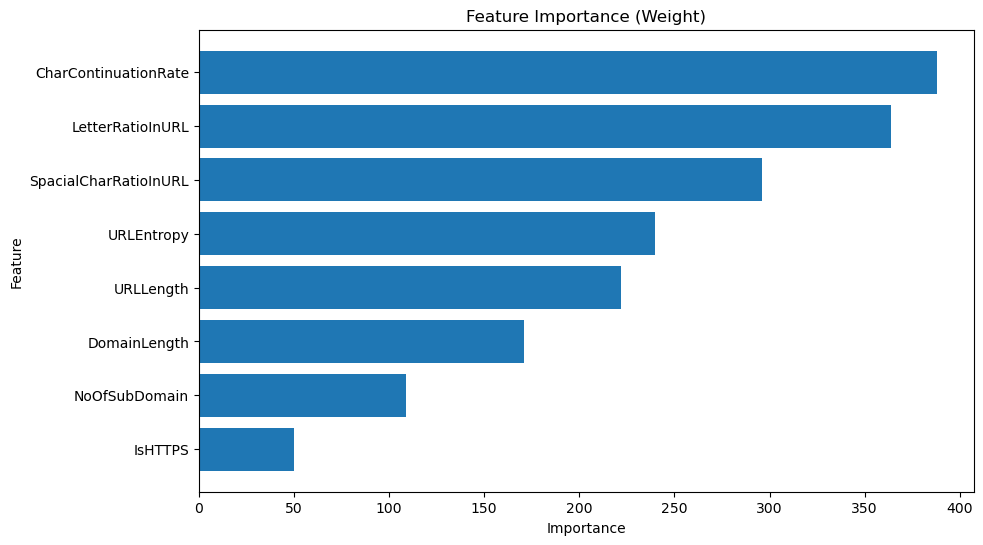

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Weight)')
plt.gca().invert_yaxis()
plt.show()

# We will drop features not present here, they did not contribute to the model
- these are 
- f3: IsDomainIP
- f6: NoOfEqualsInURL
- f7: NoOfQMarkInURL
- f12: URLEntropy

